In [80]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [96]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/Desktop/qmon-sindy")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:

params, exp_path = give_params()

gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)


In [98]:
params

[0.3, 10.0, 10.0, 1.0, 0.8, [0.0, 1.0], [10.0, 500]]

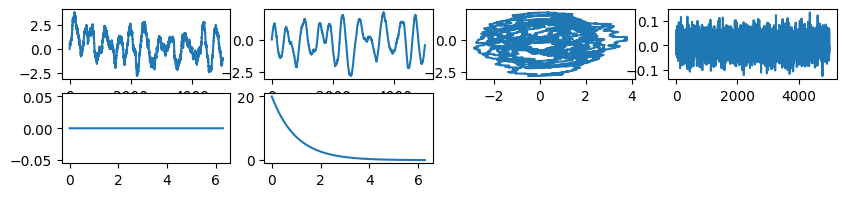

In [99]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)

plt.figure(figsize=(10,2))
ax=plt.subplot(241)
ax.plot(x[:,0])
ax=plt.subplot(242)
ax.plot(x[:,1])
ax=plt.subplot(243)
ax.plot(x[:,0],x[:,1])
ax=plt.subplot(244)
ax.plot(dy[:,0])
ax=plt.subplot(245)
ax.plot(times,f[:,0])
ax=plt.subplot(246)
ax.plot(times,f[:,1])

In [100]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


Question 2 talk w/ giulio; f should be (0,f) right ? to be a force... so we put some dynamics in one component only? Maybe it's easier but also more boring ...?

In [101]:
torch.exp(torch.tensor(-1))

tensor(0.3679)

In [102]:
class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        
        self.dt, self.simulation_params, initial_force_params = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        
        self.damping_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[0],dtype=torch.float32,
                                                              requires_grad=True))
        
        self.amplitude_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[1],dtype=torch.float32,
                                                      requires_grad=False))
        
        self.A = torch.tensor(data=[[-gamma/2, omega],[-omega,-gamma/2]], dtype=torch.float32).detach()
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()

        
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:5]
        f = state[5:-1]
        t = state[-1]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)
        
        xicov = cov.matmul(self.C.T)
        
        dx = (self.A - xicov.matmul(self.C)).matmul(x)*dt + xicov.matmul(dy)
        
        ### signal part 
        #### g0(f) = f, g1(f) = f**3<
        #dictionary = torch.concatenate([f, f**2, f**3, f**4])
       # 
        #df = self.coeffs_f.dot(dictionary) ###Check this!
        #fnew = f+ df
        fnew = torch.exp(-self.damping_force*(t+dt))*self.amplitude_force
        
        dx += fnew*dt
        
        dcov = self.dt*(cov.matmul(self.A.T) + (self.A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        

        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]]), fnew, torch.tensor([t+self.dt])])

        dy_hat = self.C.matmul(x)*self.dt

        return nstate, dy_hat

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.params = inputs_cell[1]
        self.initial_amplitude = inputs_cell[2][1]
        
    def forward(self, dys):
        dys_hat = []
        
        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.params 
        A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        t0=0.
        f0x,f0y = self.initial_amplitude 
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0], f0x, f0y, t0], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [103]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)

In [111]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [.1,[0., 20.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)
xs_hat, dys_hat = rrn(dys)

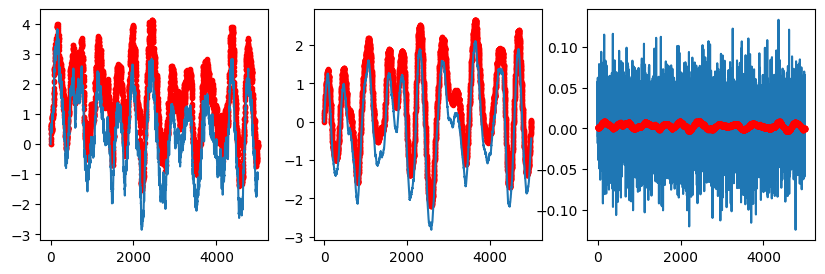

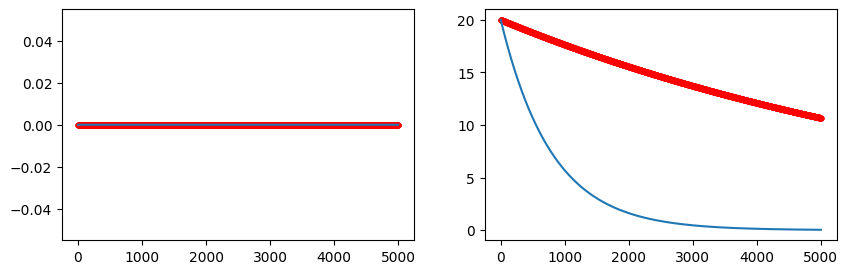

In [114]:
plt.figure(figsize=(10,3))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')
plt.show()
plt.close()


plt.figure(figsize=(10,3))
ax=plt.subplot(121)
ax.plot(xs_hat.detach().numpy()[:,5], color="red",marker='.')
ax.plot(f[:,0])
ax=plt.subplot(122)
ax.plot(xs_hat.detach().numpy()[:,6], color="red",marker='.')
ax.plot(f[:,1])



# Training

In [115]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

In [125]:
def err_f(f,xs_hat):
    return np.sum(np.abs(f - xs_hat[:-1,5:7].detach().numpy() ))/np.sum(np.abs(f))

In [ ]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [.1,[0., 20.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-1)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(rrn.parameters())]
history["gradients"] = []

for ind in tqdm(range(100)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append([k.detach().numpy() for k in list(rrn.parameters())])
    history["gradients"].append([k.grad.numpy() for k in list(rrn.parameters())])
    
    print(loss.item())
    print(err_f(f,xs_hat))
    print("\n")
    optimizer.zero_grad()

  1%|█                                                                                                            | 1/100 [00:02<04:16,  2.59s/it]

1.0128508806228638
3.674777230061666




  2%|██▏                                                                                                          | 2/100 [00:05<04:16,  2.62s/it]

1.0107508897781372
2.584445733759573




  3%|███▎                                                                                                         | 3/100 [00:07<04:13,  2.61s/it]

1.0099095106124878
1.8939078614306948




  4%|████▎                                                                                                        | 4/100 [00:10<04:12,  2.63s/it]

1.009549617767334
1.442215626437555




  5%|█████▍                                                                                                       | 5/100 [00:13<04:35,  2.90s/it]

1.0093878507614136
1.1337812972608823




  6%|██████▌                                                                                                      | 6/100 [00:16<04:27,  2.84s/it]

1.0093142986297607
0.914489132421297




  7%|███████▋                                                                                                     | 7/100 [00:19<04:17,  2.77s/it]

1.0092828273773193
0.7531861215179187




  8%|████████▋                                                                                                    | 8/100 [00:21<04:09,  2.71s/it]

1.009272575378418
0.6312536322328968




  9%|█████████▊                                                                                                   | 9/100 [00:24<04:02,  2.67s/it]

1.009272813796997
0.5370948380256955




 10%|██████████▊                                                                                                 | 10/100 [00:26<03:57,  2.64s/it]

1.009278655052185
0.46319628192485246




 11%|███████████▉                                                                                                | 11/100 [00:29<04:01,  2.72s/it]

1.0092869997024536
0.4045140861034963




 12%|████████████▉                                                                                               | 12/100 [00:32<03:54,  2.67s/it]

1.0092960596084595
0.35755257344589114




 13%|██████████████                                                                                              | 13/100 [00:34<03:49,  2.64s/it]

1.0093053579330444
0.31981914462803923




 14%|███████████████                                                                                             | 14/100 [00:37<03:46,  2.63s/it]

1.0093140602111816
0.2894912781136806




 15%|████████████████▏                                                                                           | 15/100 [00:40<03:42,  2.62s/it]

1.0093220472335815
0.26520436756180876




 16%|█████████████████▎                                                                                          | 16/100 [00:42<03:38,  2.60s/it]

1.0093291997909546
0.24591485057220908




 17%|██████████████████▎                                                                                         | 17/100 [00:45<03:41,  2.67s/it]

1.0093352794647217
0.2308077984882941




 18%|███████████████████▍                                                                                        | 18/100 [00:48<03:38,  2.66s/it]

1.009340524673462
0.2192354447086074




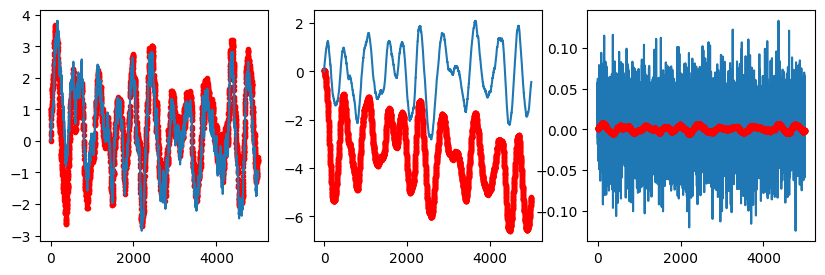

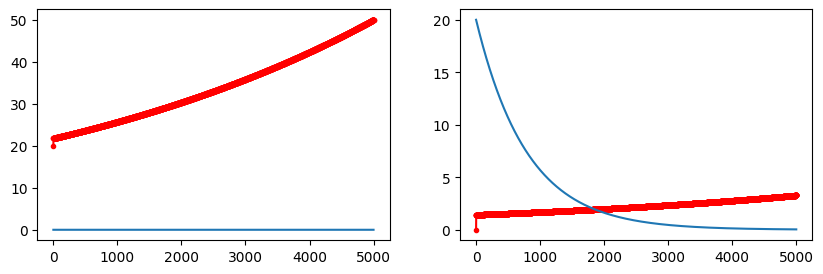

In [117]:
plt.figure(figsize=(10,3))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')
plt.show()
plt.close()


plt.figure(figsize=(10,3))
ax=plt.subplot(121)
ax.plot(xs_hat.detach().numpy()[:,5], color="red",marker='.')
ax.plot(f[:,0])
ax=plt.subplot(122)
ax.plot(xs_hat.detach().numpy()[:,6], color="red",marker='.')
ax.plot(f[:,1])


In [423]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 10*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.SGD(list(rrn.parameters()), lr=1e2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(rrn.RCell.omega_p.detach().numpy()[0])
    history["gradients"].append(rrn.RCell.omega_p.grad.numpy())
    
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.40s/it]


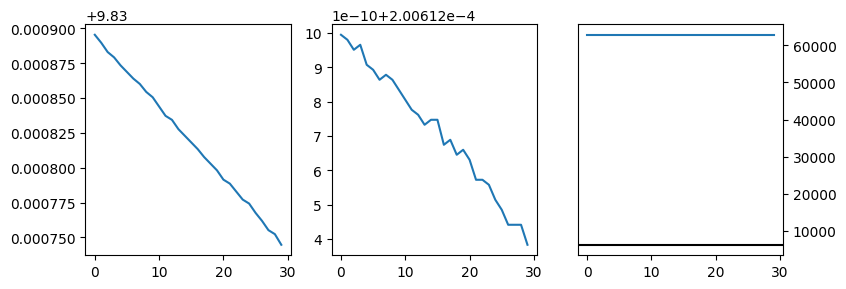

In [414]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax=plt.subplot(132)
ax.plot(history["gradients"])
ax=plt.subplot(133)
ax.plot(history["params"])
ax.axhline(omega, color="black")
ax.yaxis.tick_right()

In [155]:
history["params"]

[array([188495.52], dtype=float32),
 array([188495.52], dtype=float32),
 array([188495.52], dtype=float32)]

In [224]:
history["losses"]

[2739.5009765625, 2739.61669921875, 2739.026611328125]

In [648]:
RNN.zero_grad()
optimizer.zero_grad()

In [650]:
RNN.RCell.zero_grad()

In [274]:
class CustomModel(torch.nn.Module):
    def __init__(self,w0):
        super(CustomModel, self).__init__()
        self.w = torch.nn.Parameter(data = torch.tensor([w0], dtype=torch.float32, requires_grad=True))
        
        #self.matrix = torch.tensor(data = [[self.w, -1.],[-self.w, -1.]], dtype=torch.float32, requires_grad=True    This computes \partial_matrix(COST)
        self.matrix_trainable = self.w*torch.tensor(data=[[0,1],[-1,0]], dtype=torch.float32,requires_grad=False)
        self.matrix = self.matrix_trainable - torch.eye(2)
        
    def forward(self, x):
        return self.matrix.matmul(x)
    
def loss(pred,y):
    return torch.mean((pred- y)**2)


my_model = CustomModel(w0=0.01)
optimizer = torch.optim.Adam(lr=0.01, params=my_model.parameters())

device = torch.device("cpu")
x = torch.ones(2).to(device)
y = torch.tensor(data=[2.,0.], dtype=torch.float32).to(device)


for k in range(10):

    optimizer.zero_grad()
    my_model.zero_grad()
    pred = my_model(x)
    cost = loss(pred,y)
    cost.backward()
    optimizer.step()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [271]:
my_model.w.grad

tensor([-1.9800])

/tmp/ipykernel_8095/2094205978.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  my_model.matrix.grad


In [263]:
torch.__version__

'2.0.1+cu117'

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [221]:
dev = torch.device("cpu")


[Parameter containing:
 tensor([0.0100], requires_grad=True)]

In [220]:
loss(x,y)


AttributeError: 'function' object has no attribute 'backward'

In [214]:
class CustomModel(torch.nn.Module):
    def __init__(self,w0):
        super(CustomModel, self).__init__()
        self.w = torch.nn.Parameter(data = torch.tensor([w0], dtype=torch.float32, requires_grad=True))
            
            
    def forward(self, dy, x):
        """
        input_data is dy
        hidden_state is x
        output dy_hat
        """
       # dx = torch.matmul(torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32)*self.omega_p
        #                  + torch.tensor(data = -0.5*gamma*np.eye(2), dtype=torch.float32)- self.xicovC,x)*dt + torch.matmul(self.xicov,dy)
        # That works!
      #  dx = #self.A_symp.matmul(x)*dt#- self.xicovC).matmul(x)*dt + torch.matmul(self.xicov,dy)
       # dx = self.A_body.matmul(x)*dt
        #ss = torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32, requires_grad=True)
        #A = ss*self.omega_p + self.A_diag
        dx = self.omega_p*(AA-xicov.matmul(x)*dt 
        dy_hat = self.C.matmul(x)*self.dt
        return torch.stack([x + dx, dy_hat])

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(inputs_cell=inputs_cell)

    def forward(self, dys):
        dys_hat = []
        xs_hat = [torch.tensor([0., 0.],dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

SyntaxError: '(' was never closed (3996344217.py, line 20)

In [651]:
xs_hat, dys_hat = RNN(dys)
loss = log_lik(dys, dys_hat)
loss.backward()
optimizer.step()


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
torch.

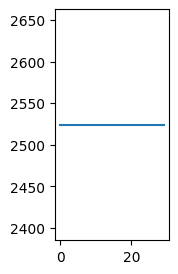

In [635]:
plt.figure(figsize=(5,3))
ax=plt.subplot(131)
ax.plot(history["losses"])

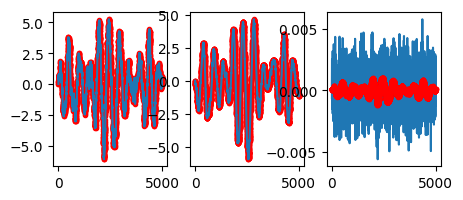

In [421]:
plt.figure(figsize=(5,2))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

In [422]:

def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(2*dt)

In [423]:
dev = torch.device("cpu")
optimizer = torch.optim.Adam(lr=0.01, params=rrn.parameters())

In [445]:
Recurrent = RecurrentNetwork(inputs_cell)

In [446]:
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)#.detach().requires_grad_(True)

In [447]:
xs_hat, dys_hat = Recurrent(dys)
#xs_hat, dys_hat = rrn(dys)

In [448]:
Recurrent.RCell.omega_p.is_leaf

True

In [449]:
rrn.zero_grad()
optimizer.zero_grad()

In [450]:
cost = log_lik(dys,dys_hat)
#cost.detach().requires_grad_(True)

In [451]:
cost.backward()

In [441]:
rrn.RCell.omega_p.detach().requires_grad_(True)

tensor([6283.1855], requires_grad=True)

In [385]:
rrn.RCell.omega_p.grad

In [49]:
class RecurrentCell(torch.nn.Module):
    def __init__(self, dt=0.001):
        super(RecurrentCell, self).__init__()
        self.params = torch.nn.Parameter(data = torch.tensor([11, 8/3, 28],dtype=torch.float32, requires_grad=True))
        self.dt = dt

    def forward(self, input_data, hidden_state):
        sigma, beta, rho = self.params
        x,y,z = hidden_state
        dx, dy, dz = sigma*(y-x), x*(rho-z) -y, x*y - beta*z
        return torch.stack([x+dx*self.dt, y+dy*self.dt, z+dz*self.dt])

class RecurrentNetwork(nn.Module):
    def __init__(self,dt=0.001):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(dt=dt)

    def forward(self, input):
        outputs = []
        h_t = torch.tensor([-8,7,27],dtype=torch.float32)
        for i, input_t in enumerate(input):
            h_t = self.RCell(None, h_t)
            outputs += [h_t]
        
        outputs = torch.stack(outputs)
        return outputs

In [68]:
Rnn = RecurrentNetwork()
times = torch.arange(0,100,0.001)
outs = Rnn(times)

In [69]:
optimizer = torch.optim.SGD(Rnn.parameters(), lr=0.01)

def MSE(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [70]:
target_traj  = np.load("data/lorenz/0_1_0.001.npy")
target = torch.tensor(target_traj,dtype=torch.float32).reshape([1000,3])
Rnn.train()

RecurrentNetwork(
  (RCell): RecurrentCell()
)

In [71]:
X = torch.tensor(times).to("cpu")
Y = target.to("cpu")
history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
        
    pred = Rnn(X)
    loss = MSE(pred, Y)
    loss.backward()
    optimizer.step()
    
    history["losses"].append(loss.item())
    history["params"].append(list(Rnn.parameters())[0].detach().numpy())
    history["gradients"].append(Rnn.RCell.params.grad.numpy())

    optimizer.zero_grad()


/tmp/ipykernel_2711/2538995262.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(times).to("cpu")
100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


In [73]:
pred = Rnn(X)
loss = MSE(pred, Y)
loss.backward()

tensor([ 1.1262, -2.3285,  5.9817])

Text(0.5, 0.92, 'Lorenz Attractor')

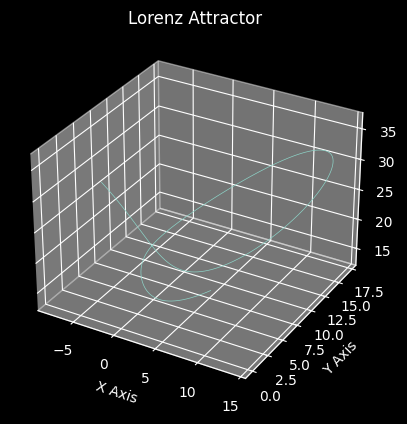

In [34]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*outs.detach().numpy().T,lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

tensor([[-7.8500,  7.1877, 26.1880],
        [-7.6996,  7.3651, 25.3983],
        [-7.5490,  7.5328, 24.6304],
        ...,
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667]], grad_fn=<StackBackward0>)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the network

for epoch in range(epochs):
    for batch, (data, target) in enumerate(train_loader):
        # Obtaining the cuda parameters
        data = data.to(device=device)
        target = target.to(device=device)

        # Reshaping to suit our model
        data = data.reshape(data.shape[0], -1)

        # Forward propagation
        score = model(data)
        loss = criterion(score, target)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [2]:
@jit(nopython=True)
def f(x,t,sigma=10, beta=8/3,rho=28):
    X,Y,Z = x
    return np.array([sigma*(Y-X), X*(rho-Z)-Y, X*Y - (beta*Z)])
@jit(nopython=True)aaaaa
def g(x,t):
    return np.zeros(3)

In [3]:
dt = 0.001
times = np.arange(0,100,dt)
x0=np.array([-8,7,27])
xx1 = integrate(f,g,x0,times,dt,mode="euler")
xx2 = integrate(f,g,x0,times,dt,mode="RK4")

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

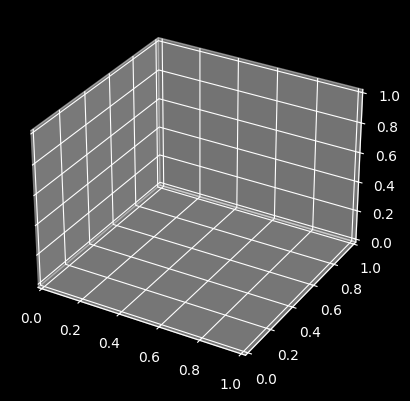

In [9]:
import os 

os.makedirs("data/trajs/lorenz/",exist_ok=True)
np.save("data/trajs/lorenz/1",xx1)